# Compare grass growth time series using MERA for each county at a weekly frequency

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

In [2]:
df1 = pd.read_csv(os.path.join(
        "data", "grass_growth", "pasturebase", "pasturebase_cleaned.csv"
))
df2 = pd.read_csv(os.path.join(
    "data", "grass_growth", "grasscheck", "grasscheck_cleaned.csv"
))
df = pd.concat([df1, df2])
df_p = pd.pivot_table(
    df[["time", "county", "value"]],
    values="value", index=["time"], columns=["county"]
)
df_p.index = pd.to_datetime(df_p.index)

In [3]:
mera = pd.read_csv(
    os.path.join("data", "ModVege", "growth", "MERA_growth_week_pasture.csv")
)
mera.rename(columns={"COUNTY": "county", "mean": "value"}, inplace=True)
mera["county"] = mera["county"].str.title()
mera_p = pd.pivot_table(
    mera, values="value", index=["time"], columns=["county"]
)
mera_p.index = pd.to_datetime(mera_p.index)

In [4]:
counties = list(df_p)

In [5]:
df["data"] = "Measured"
mera["data"] = "Simulated"
data_all = pd.concat([df, mera])
data_all.set_index("time", inplace=True)
data_all.index = pd.to_datetime(data_all.index)
# data_all_p = pd.pivot_table(
#     data_all[["county", "value", "data"]],
#     values="value", index=["time"], columns=["county", "data"]
# )
# data_all_p.resample("Y").mean()

## Long-term averages

In [6]:
lta_all = pd.DataFrame(df_p.mean(), columns=["All seasons"]).sort_values(
    by="All seasons"
)

In [7]:
lta_mam = pd.DataFrame(
    df_p[
        (df_p.index.month == 3) | (df_p.index.month == 4) |
        (df_p.index.month == 5)
    ].mean(),
    columns=["MAM"]
).sort_values(by="MAM")

In [8]:
lta_jja = pd.DataFrame(
    df_p[
        (df_p.index.month == 6) | (df_p.index.month == 7) |
        (df_p.index.month == 8)
    ].mean(),
    columns=["JJA"]
).sort_values(by="JJA")

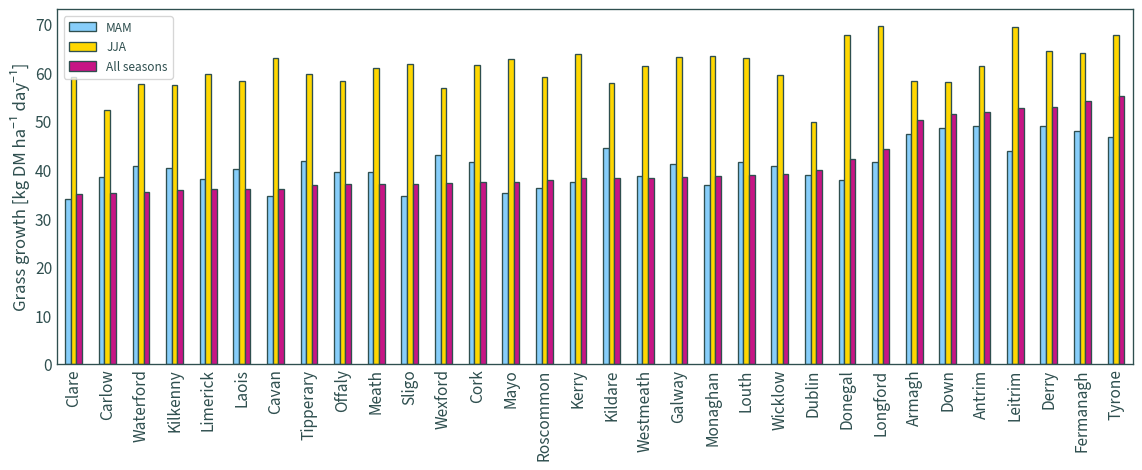

In [10]:
pd.concat([lta_mam, lta_jja, lta_all], axis=1).sort_values(
    by=["All seasons", "JJA", "MAM"]
).plot.bar(
    figsize=(12, 5), edgecolor="darkslategrey",
    color=["lightskyblue", "gold", "mediumvioletred"]
)
plt.xlabel("")
plt.ylabel("Grass growth [kg DM ha⁻¹ day⁻¹]")
plt.tight_layout()
plt.show()

## Weekly time series plots

Antrim


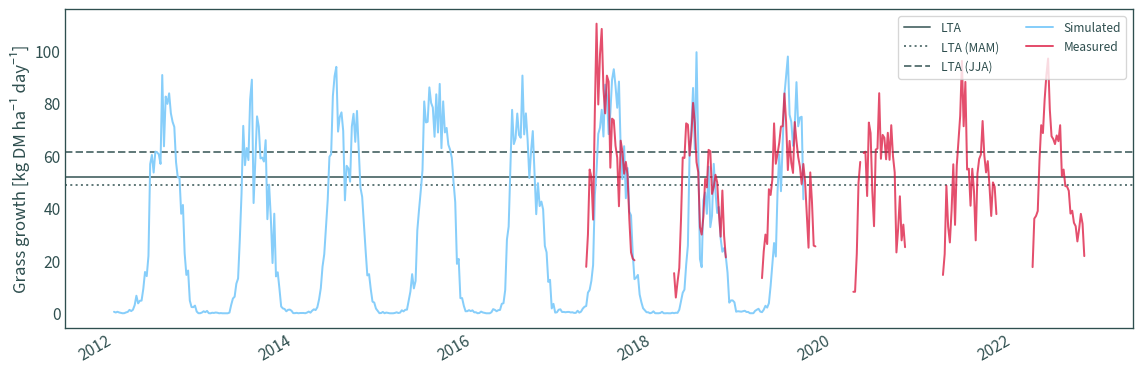

Armagh


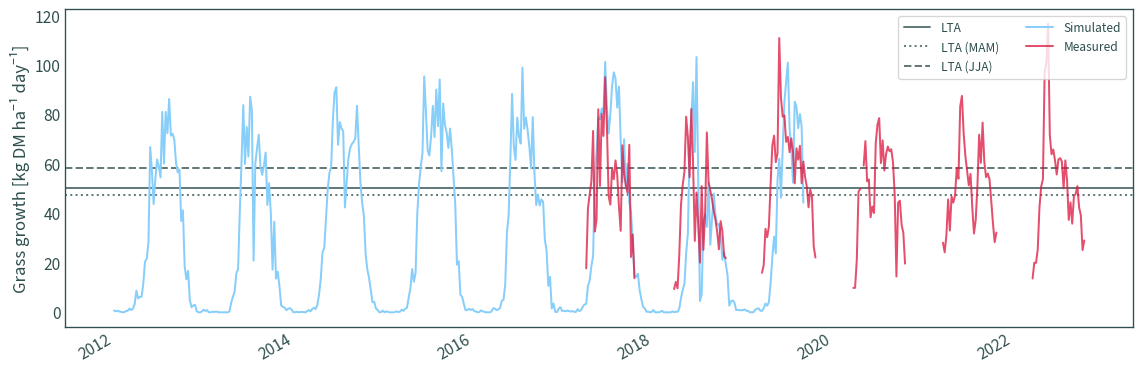

Carlow


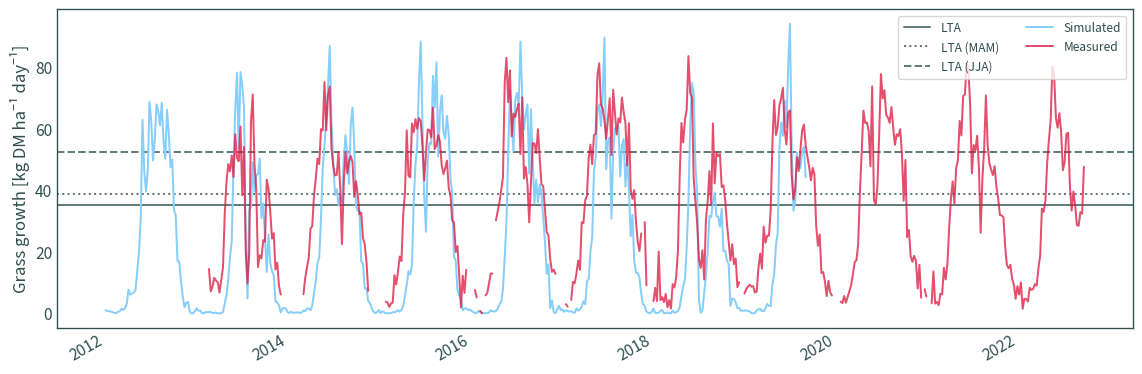

Cavan


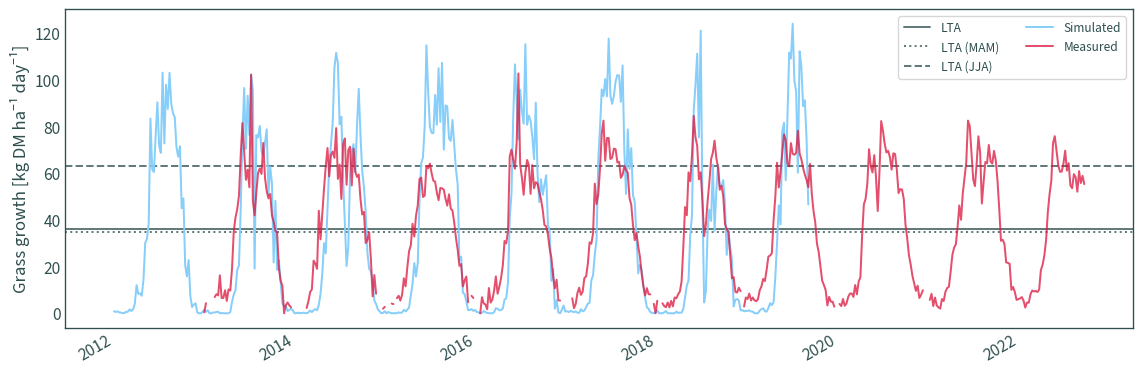

Clare


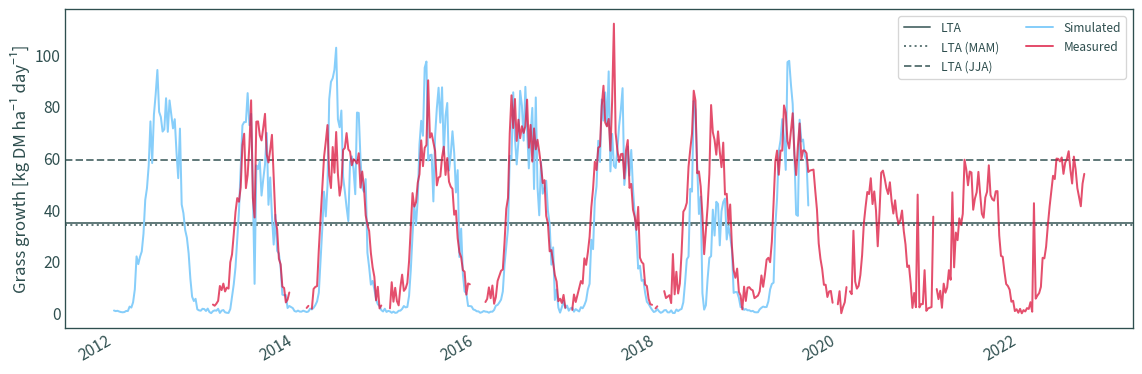

Cork


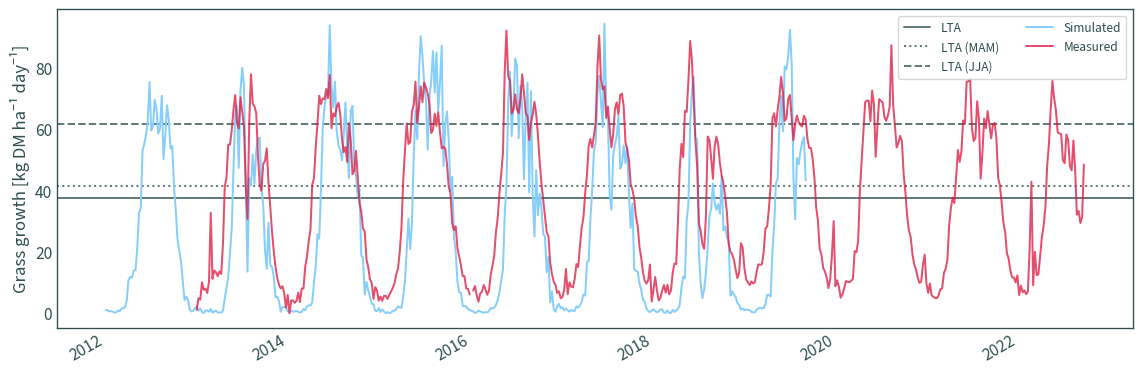

Derry


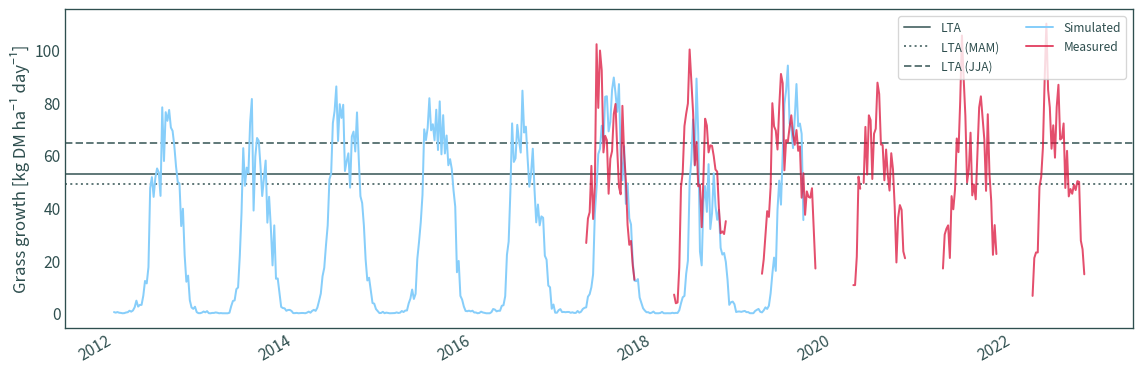

Donegal


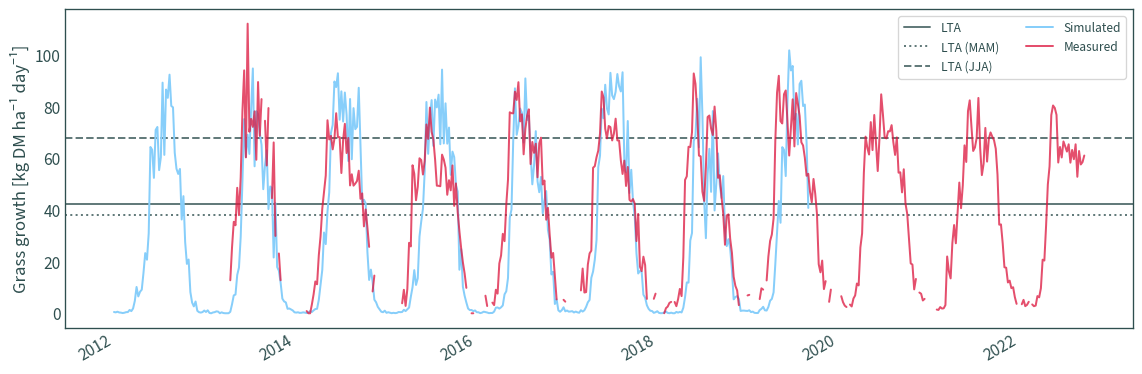

Down


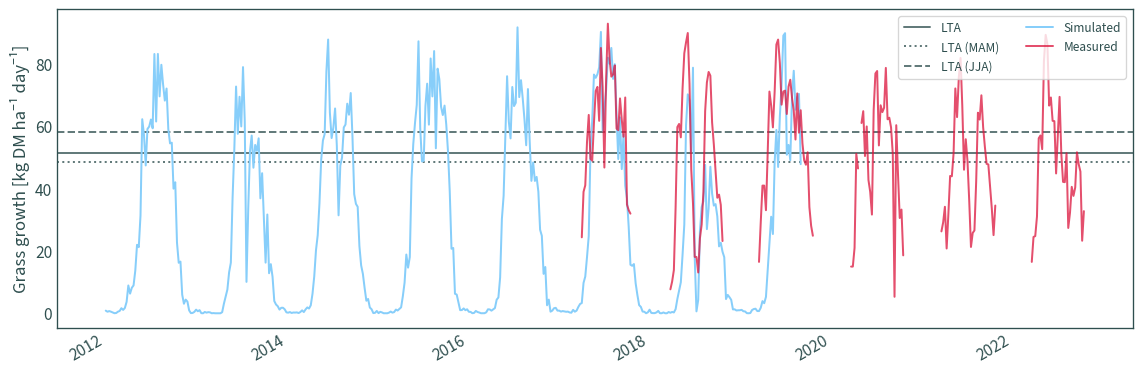

Dublin


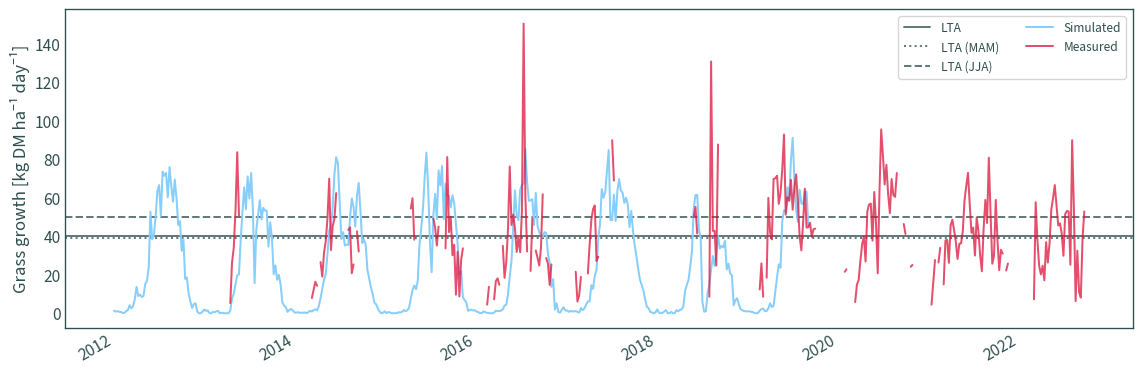

Fermanagh


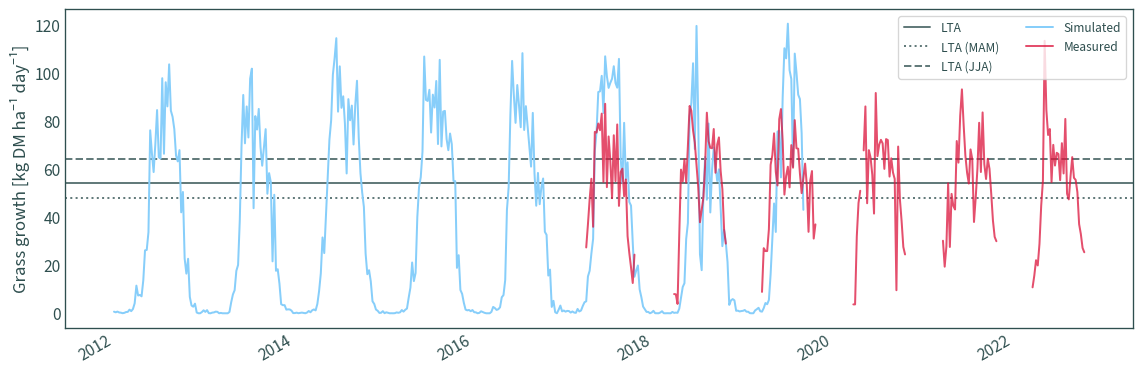

Galway


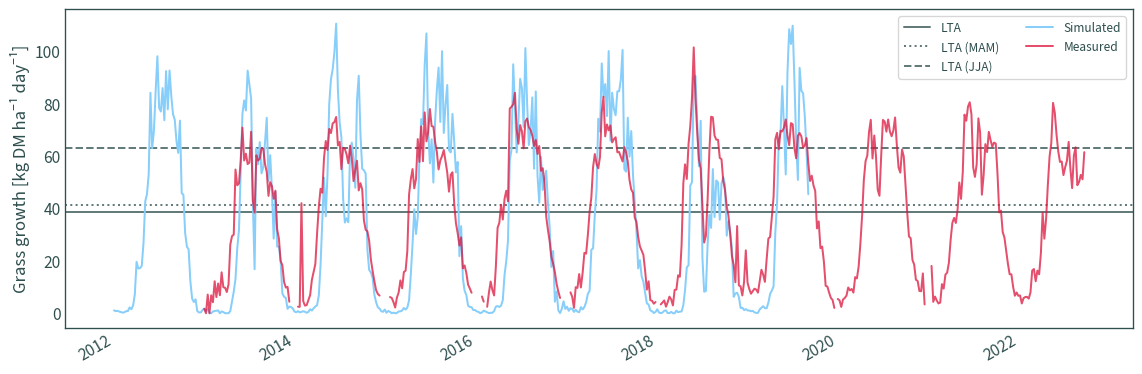

Kerry


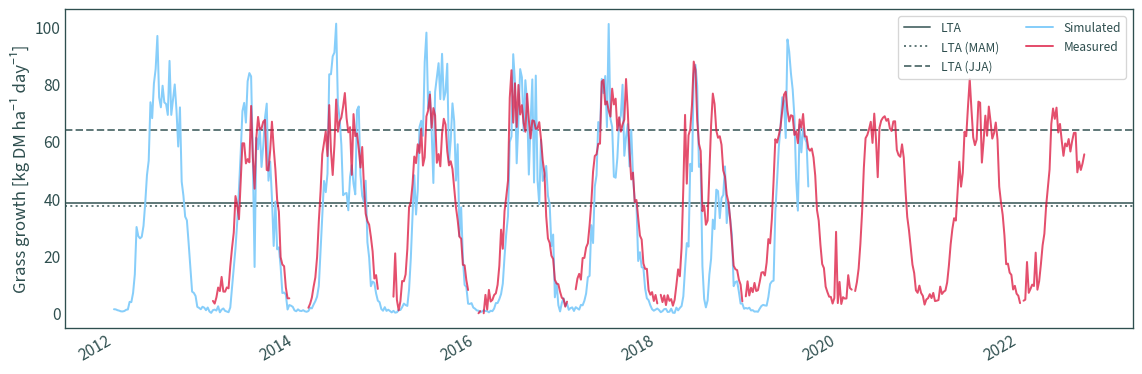

Kildare


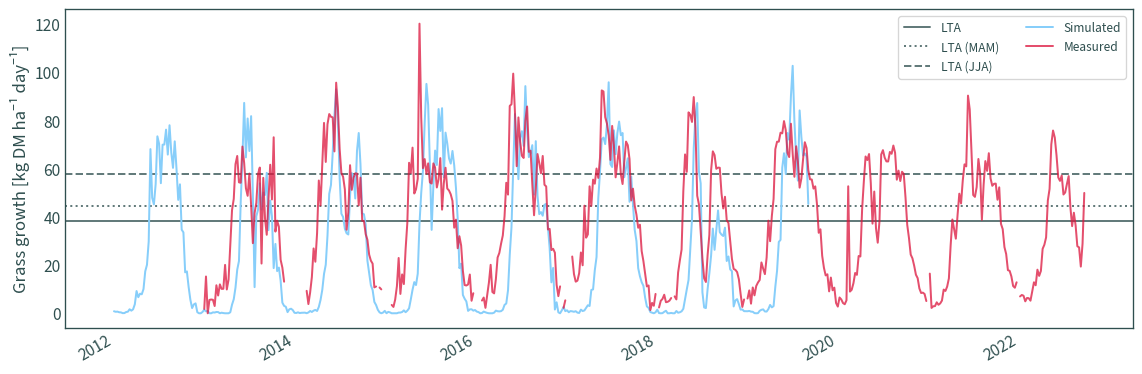

Kilkenny


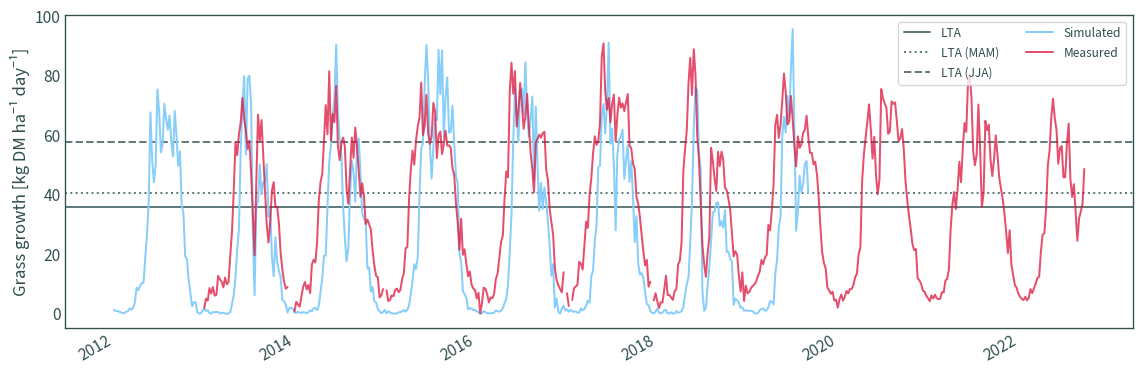

Laois


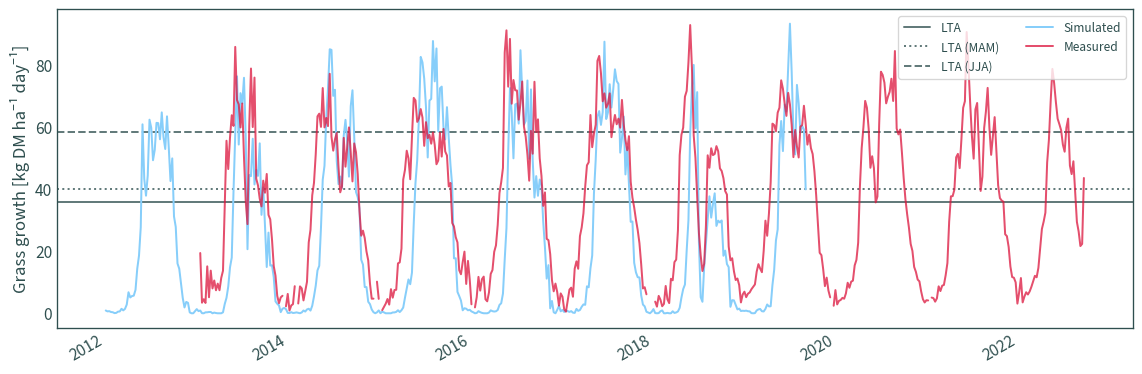

Leitrim


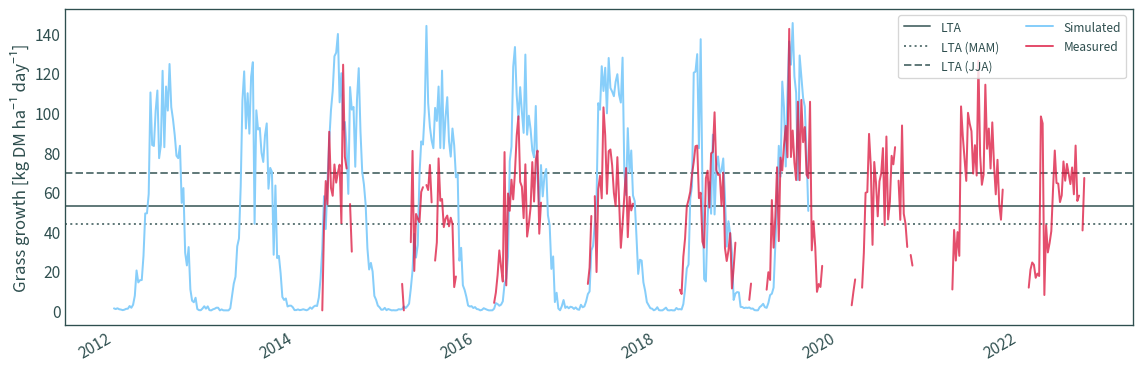

Limerick


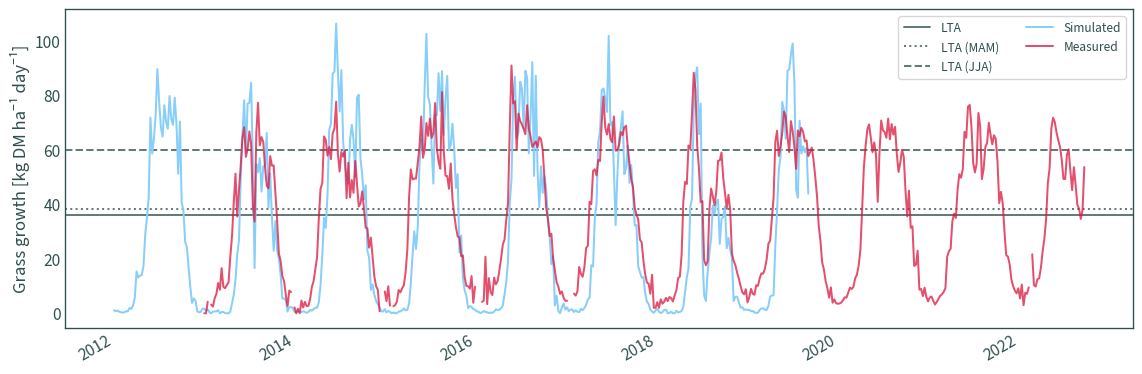

Longford


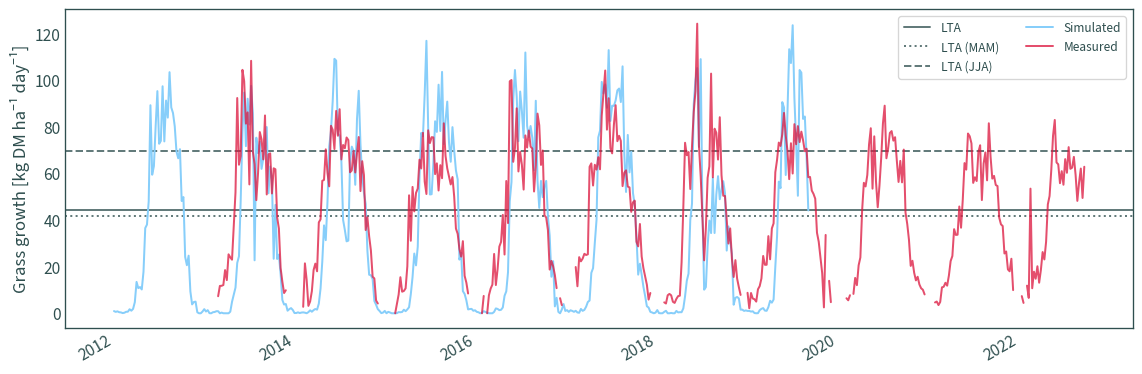

Louth


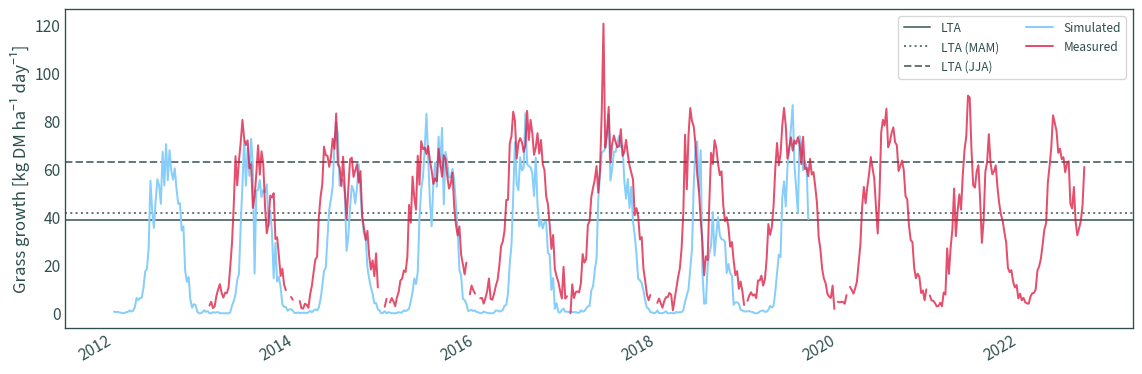

Mayo


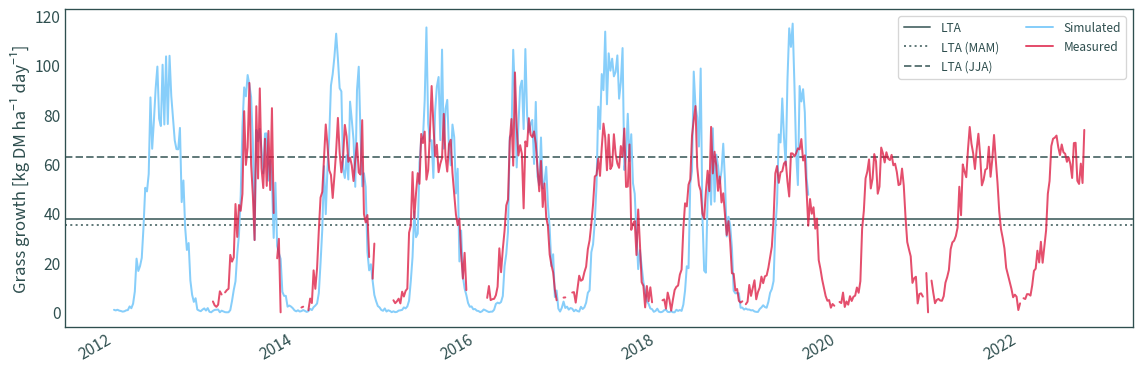

Meath


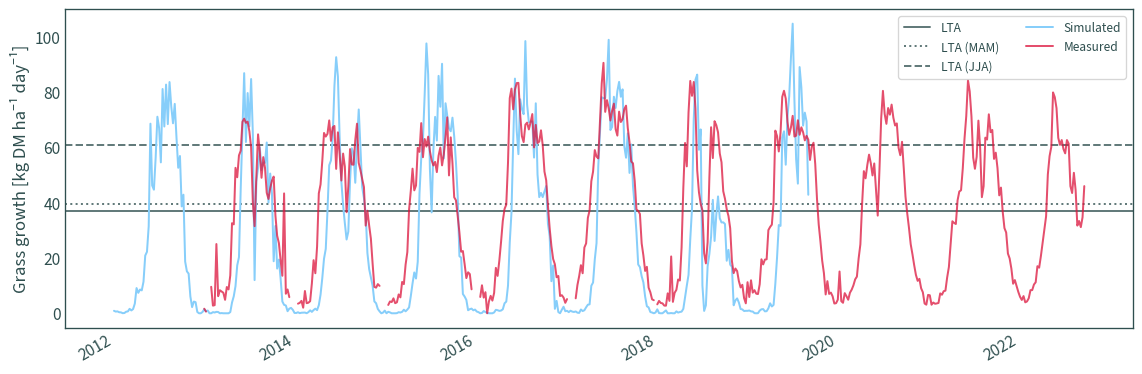

Monaghan


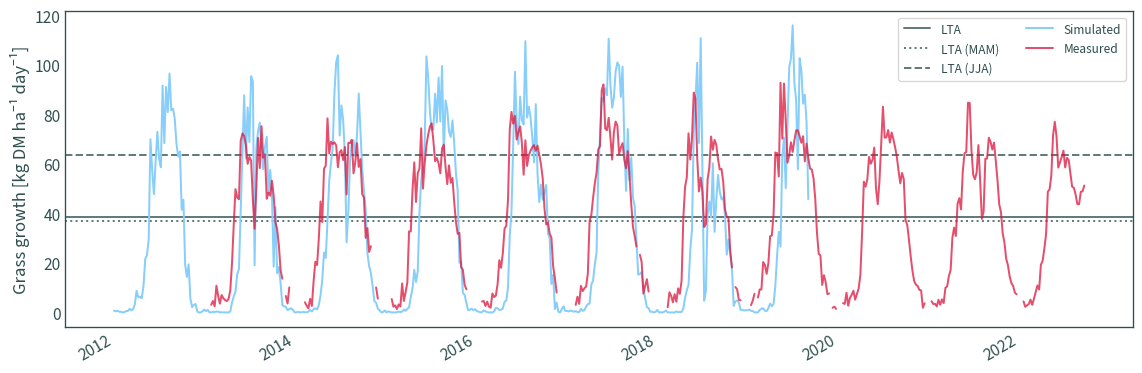

Offaly


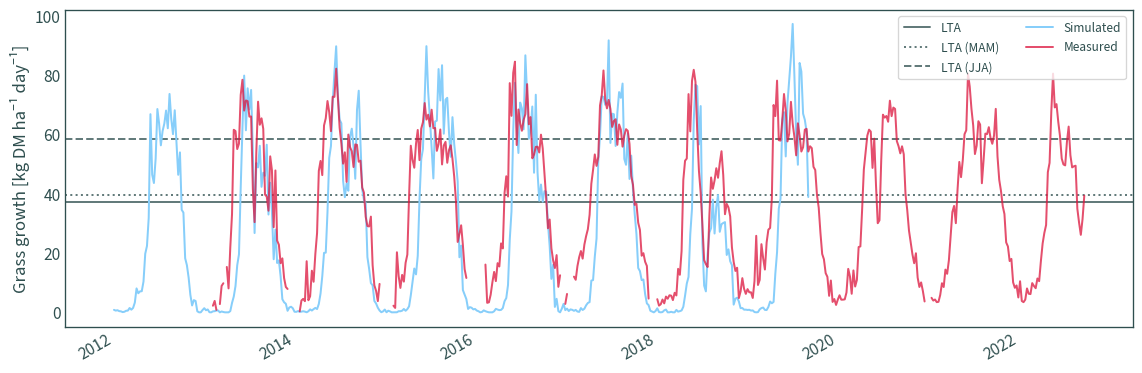

Roscommon


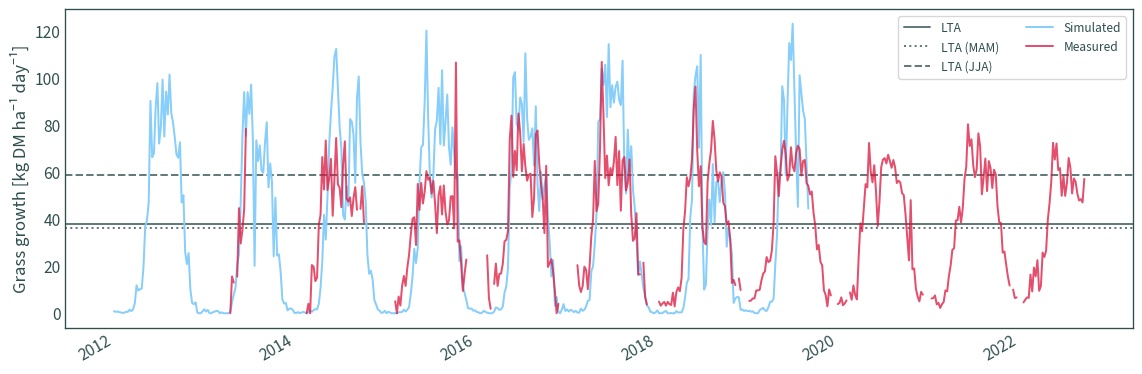

Sligo


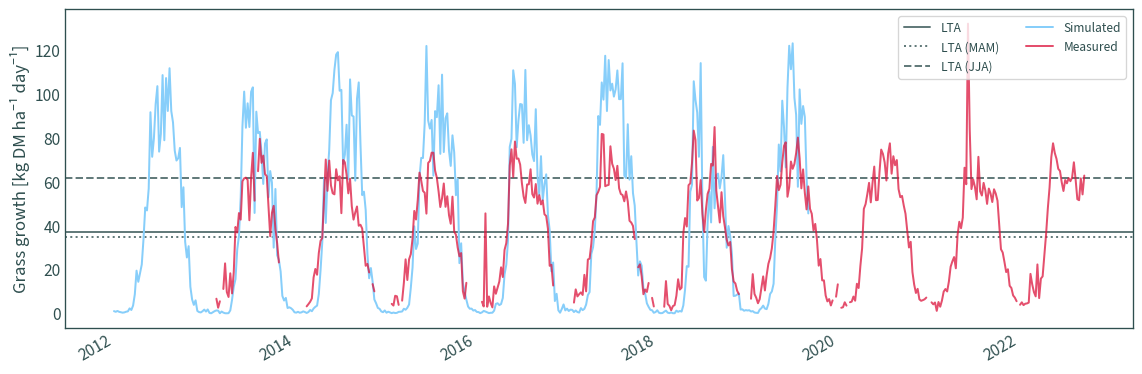

Tipperary


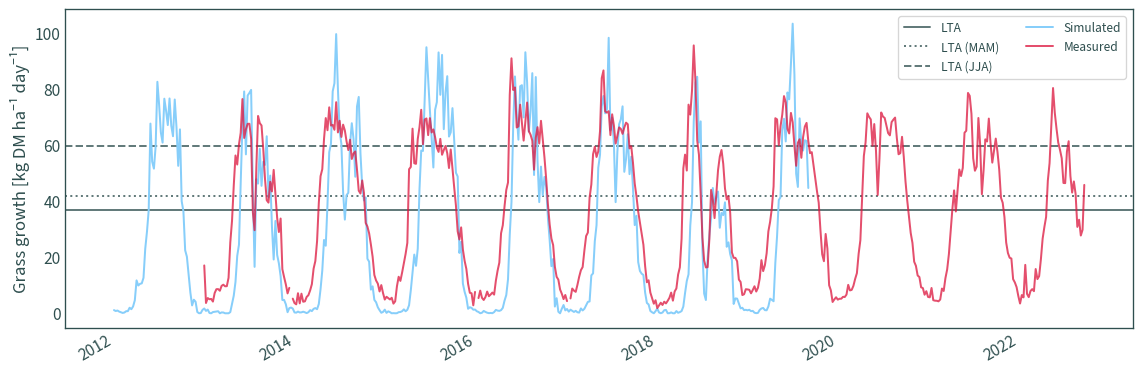

Tyrone


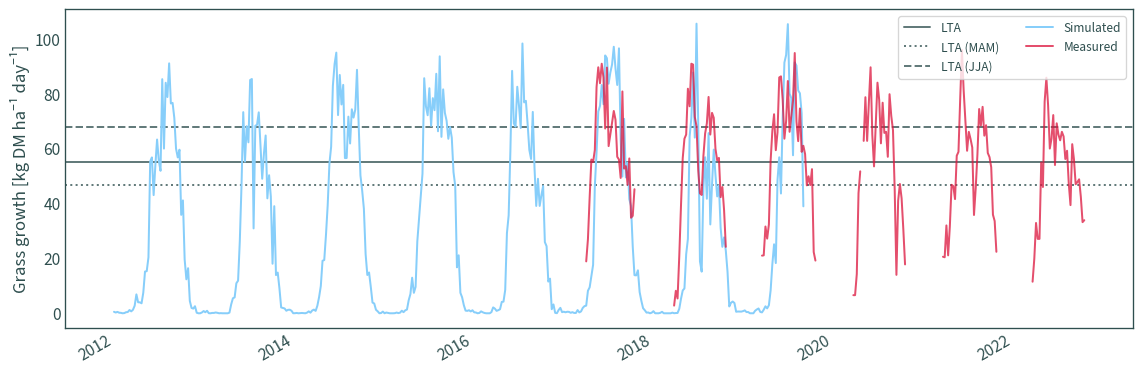

Waterford


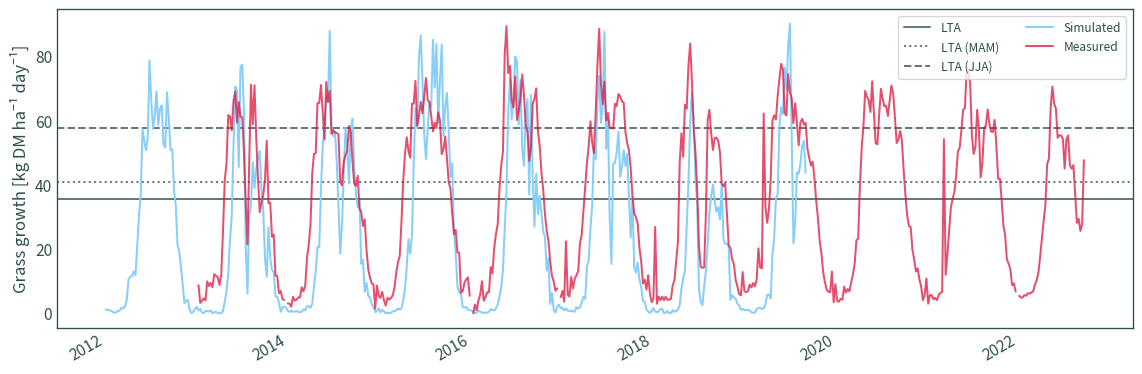

Westmeath


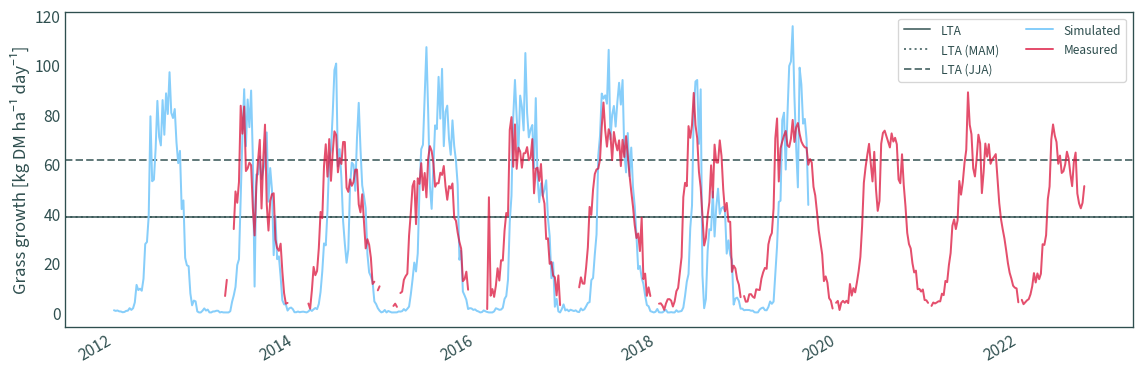

Wexford


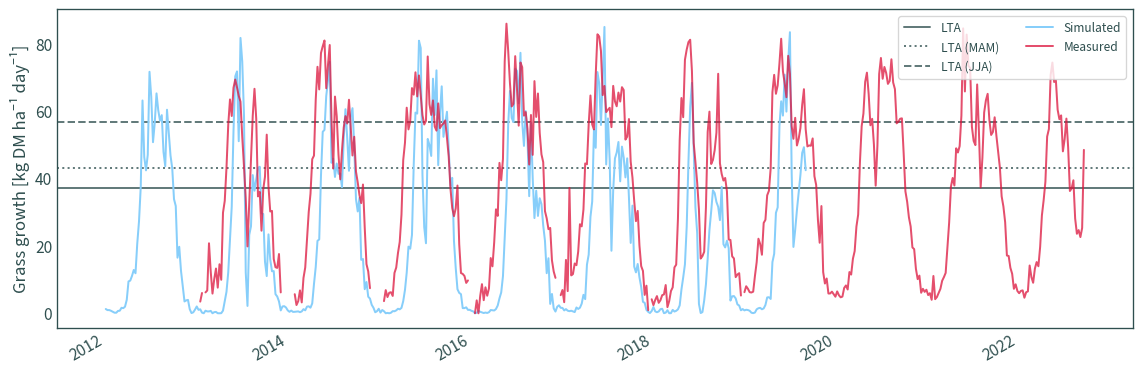

Wicklow


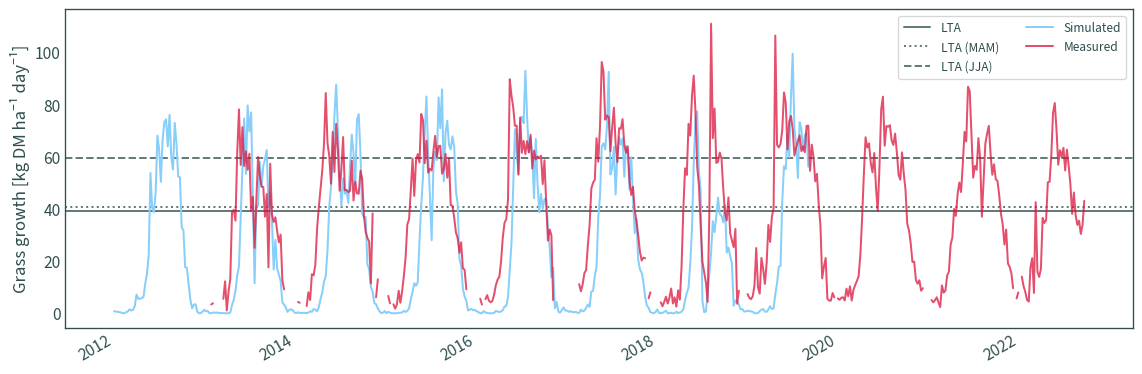

In [67]:
for county in counties:
    plt.axhline(
        y=float(lta_all.loc[county]), linestyle="solid", label="LTA",
        color="darkslategrey", alpha=.75
    )
    plt.axhline(
        y=float(lta_mam.loc[county]), linestyle="dotted", label="LTA (MAM)",
        color="darkslategrey", alpha=.75
    )
    plt.axhline(
        y=float(lta_jja.loc[county]), linestyle="dashed", label="LTA (JJA)",
        color="darkslategrey", alpha=.75
    )
    fig = mera_p["2012":"2019"][county].plot(
        figsize=(12, 4), label="Simulated", color="lightskyblue"
    )
    df_p[county].plot(
        ax=fig.axes, label="Measured", color="crimson", alpha=.75
    )
    plt.legend(title=None, ncols=2, loc="upper right")
    plt.xlabel("")
    plt.ylabel("Grass growth [kg DM ha⁻¹ day⁻¹]")
    # plt.title(county)
    plt.tight_layout()
    print(county)
    plt.show()

## Stats

In [68]:
def get_plot_data(data_m, data_s, county, season=None):
    if county is None:
        plot_data = pd.merge(
            data_m.melt(ignore_index=False).reset_index().set_index(
                ["time", "county"]
            ).rename(columns={"value": "Measured"}),
            data_s.melt(ignore_index=False).reset_index().set_index(
                ["time", "county"]
            ).rename(columns={"value": "Simulated"}),
            left_index=True, right_index=True
        ).dropna().reset_index().set_index("time")
    else:
        plot_data = pd.merge(
            data_m[[county]].rename(columns={county: "Measured"}),
            data_s[[county]].rename(columns={county: "Simulated"}),
            left_index=True, right_index=True
        ).dropna()
    if season == "MAM":
        plot_data = plot_data[
            (plot_data.index.month == 3) | (plot_data.index.month == 4) |
            (plot_data.index.month == 5)
        ]
    elif season == "JJA":
        plot_data = plot_data[
            (plot_data.index.month == 6) | (plot_data.index.month == 7) |
            (plot_data.index.month == 8)
        ]
    # elif season == "MarOct":
    #     plot_data = plot_data[
    #         (plot_data.index.month != 1) & (plot_data.index.month != 2) &
    #         (plot_data.index.month != 11) & (plot_data.index.month != 12)
    #     ]

    return plot_data

In [69]:
def rmse_by_county(data_m, data_s, counties=counties, season=None):
    if season:
        col_name = season
    else:
        col_name = "All seasons"
    rmse = pd.DataFrame(columns=["County", col_name])
    for i, county in enumerate(counties):
        plot_data = get_plot_data(data_m, data_s, county, season)
        rmse.loc[i] = [
            county,
            mean_squared_error(
                plot_data["Measured"], plot_data["Simulated"], squared=False
            )
        ]
    plot_data = get_plot_data(data_m, data_s, county=None, season=season)
    rmse.loc[i] = [
        "All counties",
        mean_squared_error(
            plot_data["Measured"], plot_data["Simulated"], squared=False
        )
    ]
    # rmse.sort_values(by=[col_name], inplace=True)
    return rmse

In [79]:
def rmse_all(data_m, data_s):
    plot_data = pd.merge(
        pd.merge(
            rmse_by_county(df_p, mera_p, season="MAM"),
            rmse_by_county(df_p, mera_p, season="JJA"),
            on="County"
        ),
        rmse_by_county(df_p, mera_p, season=None),
        on="County"
    )
    plot_data.sort_values(by="All seasons", inplace=True)
    return plot_data

In [80]:
def get_linear_regression(data_m, data_s, county, season=None):

    plot_data = get_plot_data(data_m, data_s, county, season)
    if county:
        print(county)

    x = plot_data["Measured"]
    y = plot_data["Simulated"]

    model = sm.OLS(y, sm.add_constant(x))
    results = model.fit()

    print(results.summary())

    # fig = plot_data.plot.scatter(
    #     x="Measured", y="Simulated", marker="x", color="dodgerblue"
    # )
    fig = sns.jointplot(
        x="Measured", y="Simulated", data=plot_data, color="lightskyblue",
        marginal_kws=dict(bins=25)
    )
    # x = y line
    plt.axline(
        (0, 0), slope=1, color="mediumvioletred", linestyle="dotted",
        linewidth=2
    )
    b, m = results.params
    plt.axline(
        (0, b), slope=m, label=f"$y = {m:.2f}x {b:+.2f}$",
        color="crimson", linewidth=2
    )
    plt.xlim([-5, 155])
    plt.ylim([-5, 155])
    plt.legend()
    # plt.axis("equal")
    plt.xlabel("Measured [kg DM ha⁻¹ day⁻¹]")
    plt.ylabel("Simulated [kg DM ha⁻¹ day⁻¹]")
    plt.tight_layout()
    plt.show()

### RMSE

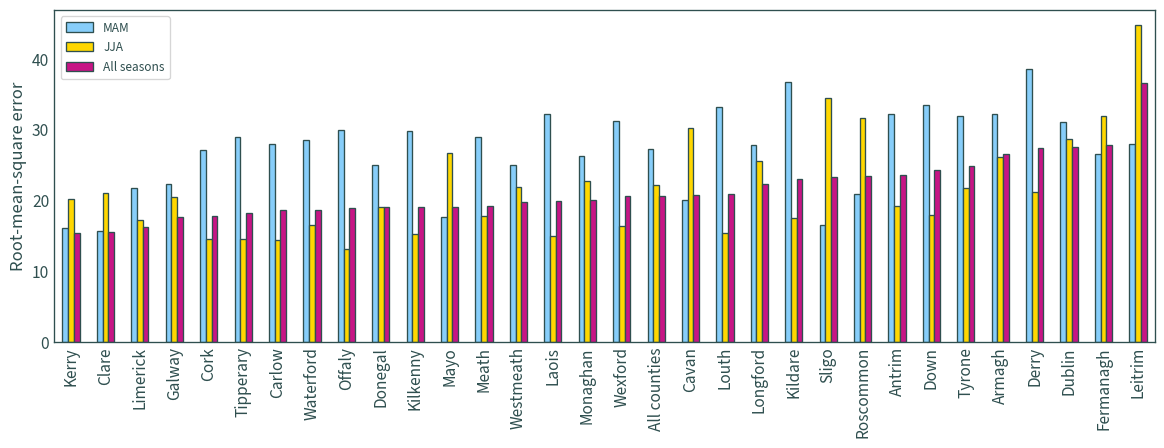

In [64]:
rmse_all(df_p, mera_p).plot.bar(
    figsize=(12, 5), x="County", edgecolor="darkslategrey",
    color=["lightskyblue", "gold", "mediumvioletred"]
)
plt.xlabel("")
plt.ylabel("Root-mean-square error")
plt.tight_layout()
plt.show()

### Linear regression - all counties

#### MAM

                            OLS Regression Results                            
Dep. Variable:              Simulated   R-squared:                       0.557
Model:                            OLS   Adj. R-squared:                  0.557
Method:                 Least Squares   F-statistic:                     3083.
Date:                Wed, 26 Apr 2023   Prob (F-statistic):               0.00
Time:                        12:05:22   Log-Likelihood:                -10339.
No. Observations:                2450   AIC:                         2.068e+04
Df Residuals:                    2448   BIC:                         2.069e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.6010      0.633    -16.753      0.0

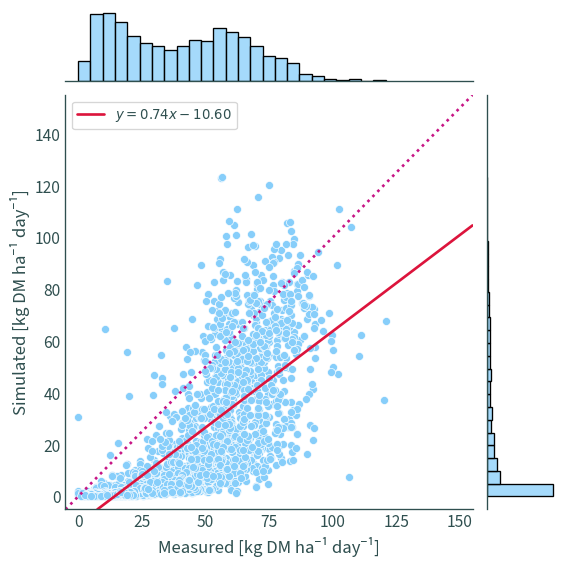

In [13]:
get_linear_regression(df_p, mera_p, county=None, season="MAM")

#### JJA

                            OLS Regression Results                            
Dep. Variable:              Simulated   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.217
Method:                 Least Squares   F-statistic:                     707.7
Date:                Wed, 26 Apr 2023   Prob (F-statistic):          7.39e-138
Time:                        12:05:29   Log-Likelihood:                -11467.
No. Observations:                2558   AIC:                         2.294e+04
Df Residuals:                    2556   BIC:                         2.295e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.6125      1.862      9.994      0.0

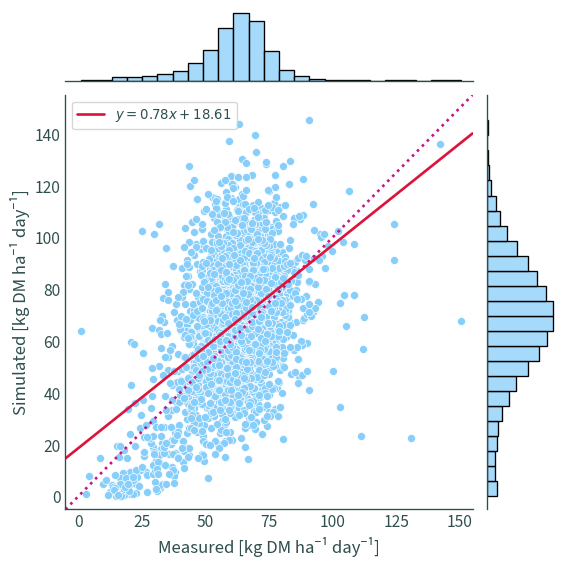

In [14]:
get_linear_regression(df_p, mera_p, county=None, season="JJA")

#### All seasons

                            OLS Regression Results                            
Dep. Variable:              Simulated   R-squared:                       0.630
Model:                            OLS   Adj. R-squared:                  0.630
Method:                 Least Squares   F-statistic:                 1.437e+04
Date:                Wed, 26 Apr 2023   Prob (F-statistic):               0.00
Time:                        12:05:33   Log-Likelihood:                -37213.
No. Observations:                8452   AIC:                         7.443e+04
Df Residuals:                    8450   BIC:                         7.444e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.6232      0.399    -16.619      0.0

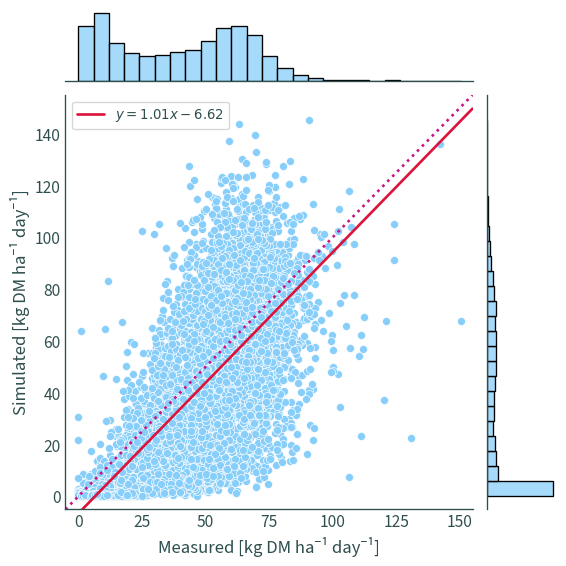

In [15]:
get_linear_regression(df_p, mera_p, county=None)

## Box plots

In [54]:
def box_plots(counties, season):
    for county in counties:
        plot_data = data_all[(data_all["county"] == county)]
        # keep season data
        if season == "MAM":
            plot_data = plot_data[
                (plot_data.index.month == 3) | (plot_data.index.month == 4) |
                (plot_data.index.month == 5)
            ]
        elif season == "JJA":
            plot_data = plot_data[
                (plot_data.index.month == 6) | (plot_data.index.month == 7) |
                (plot_data.index.month == 8)
            ]
        fig, ax = plt.subplots(figsize=(15, 5))
        sns.boxplot(
            x=plot_data.index.year, y=plot_data["value"],
            hue=plot_data["data"], ax=ax, palette="Pastel1", showmeans=True,
            meanprops={
                "markeredgecolor": "darkslategrey",
                "marker": "d",
                "markerfacecolor": (1, 1, 0, 0),
                "markersize": 4.5
            },
            flierprops={
                "marker": "o",
                "markerfacecolor": (1, 1, 0, 0),
                "markeredgecolor": "darkslategrey"
            },
            boxprops={"edgecolor": "darkslategrey", "alpha": .75},
            whiskerprops={"color": "darkslategrey", "alpha": .75},
            capprops={"color": "darkslategrey", "alpha": .75},
            medianprops={"color": "darkslategrey", "alpha": .75}
        )
        plt.xlabel("")
        ax.tick_params(axis="x", rotation=90)
        plt.ylabel("Grass growth [kg DM ha⁻¹ day⁻¹]")
        # plt.title(county)
        plt.legend(title=None)
        plt.tight_layout()
        print(county)
        plt.show()

### MAM growth grouped by year

Wexford


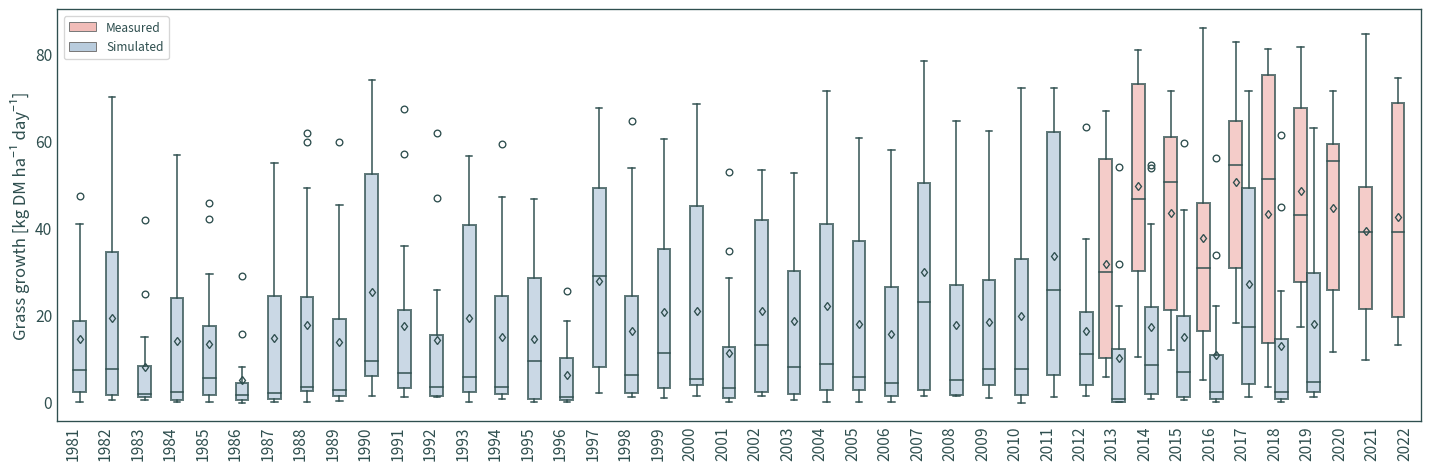

In [55]:
box_plots(["Wexford"], "MAM")

### JJA growth grouped by year

Wexford


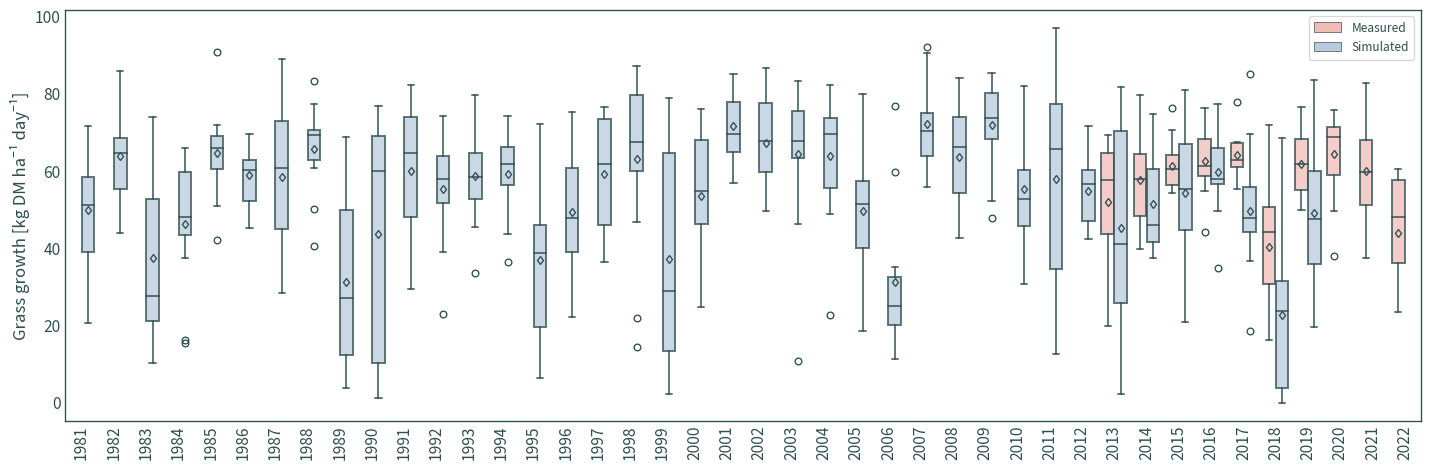

In [34]:
box_plots(["Wexford"], "JJA")